# Prepare data for autoencoders

In [14]:
!pip install tqdm
!pip install lxml

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 6.3 MB 17.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [56]:
import os
import zipfile
from tqdm import tqdm
from lxml import etree
import xml.etree.ElementTree as ET
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [21]:
def extract_image(img_path, ann_path, target_folder):
    img = cv2.imread(img_path)
    tree = ET.parse(ann_path)
    root = tree.getroot()            

    for elem in tree.iter():
        if 'object' in elem.tag:
            class_name = None
            coords = dict()
            for attr in list(elem):
                if 'name' in attr.tag:
                    class_name = attr.text
                if 'bndbox' in attr.tag:
                    for data in list(attr):
                        coords[data.tag] = int(data.text)
            if not class_name is None and len(coords.keys()) == 4:
                filename = 'IMG_{}.jpg'.format(len(os.listdir(target_folder)) + 1)
                # get roi
                sub_img = img[coords['ymin']:coords['ymax'], coords['xmin']:coords['xmax']]
                cv2.imwrite(os.path.join(target_folder, filename), sub_img)

## Extract bounding box from zip images

In [31]:
root_folder = '/home/data_pj_flores'
zips_folder = os.path.join(root_folder, 'filtered_batches')
zip_list = [x for x in os.listdir(zips_folder) if x.endswith('.zip')]

print('Found {} zip files'.format(len(zip_list)))

Found 65 zip files


In [32]:
tmp_folder = os.path.join(root_folder, 'tmp_folder')

In [39]:
extracted_folder = os.path.join(root_folder, 'XImages')
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)

In [37]:
for idx, zip_file in enumerate(zip_list):
    if (idx + 1) % 10 == 0:
        print('{}/{} Extracting {}'.format(idx + 1, len(zip_list), zip_file))
    if os.path.exists(tmp_folder):
        shutil.rmtree(tmp_folder)
    os.makedirs(tmp_folder)
    
    with zipfile.ZipFile(os.path.join(zips_folder, zip_file), 'r') as zip_ref:
        zip_ref.extractall(tmp_folder)
    images_batch = [x for x in os.listdir(tmp_folder) if x.endswith('.jpg')]
    annotations_batch = [x for x in os.listdir(tmp_folder) if x.endswith('.xml')]
    for image_name in images_batch:
        ann_name = image_name.split('.')[0] + '.xml'
        if ann_name in annotations_batch:
            extract_image(os.path.join(tmp_folder, image_name), 
                          os.path.join(tmp_folder, ann_name), 
                          extracted_folder)
print('Completed')

Completed


## Data exploration

In [47]:
def display_one_row(disp_images, num_rows, num_cols, offset):
    for idx, test_image in enumerate(disp_images):
        plt.subplot(num_rows, num_cols, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(test_image)

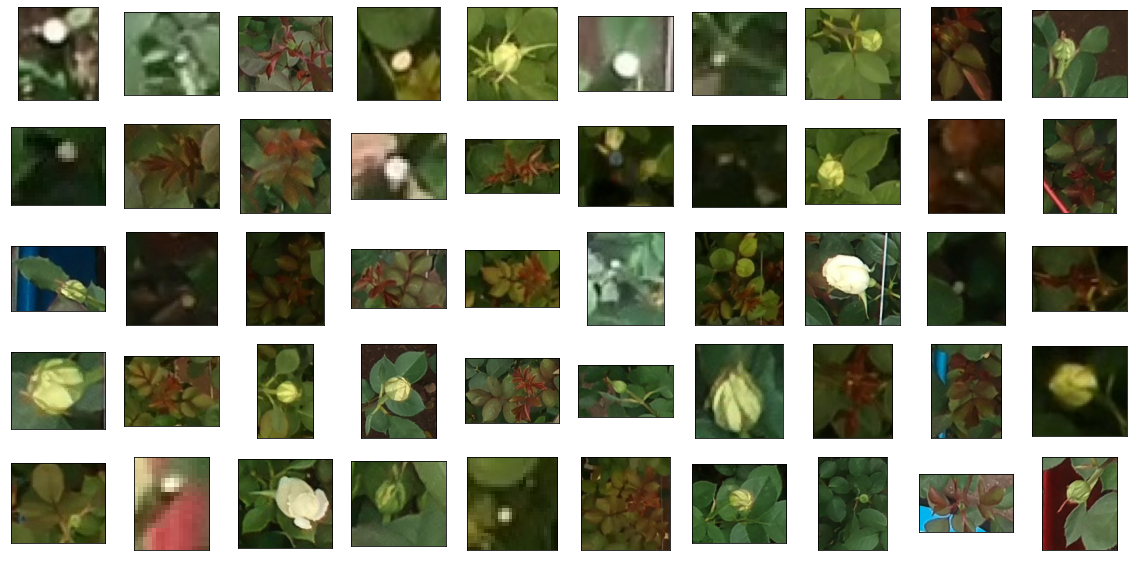

In [48]:
num_rows = 5
num_cols = 10
images_list = os.listdir(extracted_folder)
plt.figure(figsize=(20, 10))
for i in range(num_rows):
    random_images = random.sample(images_list, num_cols)
    images = [Image.open(os.path.join(extracted_folder, img_name)) for img_name in random_images]
    display_one_row(images, num_rows, num_cols, num_cols * i)

## Check images dimension

In [74]:
widths = []
heights = []
ratios = []

for img_name in images_list:
    img = Image.open(os.path.join(extracted_folder, img_name))
    width, height = img.size
    widths.append(width)
    heights.append(height)
    ratios.append(float(width) / height)

In [75]:
print('Max width: {} - Min width: {}'.format(np.max(widths), np.min(widths)))
print('Max height: {} - Min height: {}'.format(np.max(heights), np.min(heights)))
print('Max ratio: {} - Min ratio: {}'.format(np.max(ratios), np.min(ratios)))

Max width: 378 - Min width: 9
Max height: 335 - Min height: 8
Max ratio: 3.888888888888889 - Min ratio: 0.25925925925925924
